这次使用深度学习方法来做文本生成任务

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

这次使用char-level来生成文本，所以我们的起始标识与结束标识要更改

In [3]:
BOS, EOS = ' ', '\n'

data = pd.read_json('./arxivData.json')
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1).apply(lambda line: BOS + line.replace(EOS, ' ') + EOS).tolist()

In [4]:
all_text = ' '.join(lines)

In [5]:
chars = sorted(set(all_text))
n_chars = len(chars)
print(chars[50:70])
print(n_chars)

['Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd']
136


In [6]:
char_to_id = {c:i for i, c in enumerate(chars)}
id_to_char = {i:c for c,i in char_to_id.items()}

### 第一步，我们先把文本转换为[batch_size,sequence_length]的格式  

In [82]:
def to_matrix(lines, max_len=None, pad=char_to_id[EOS], dtype='int32'):
    '''将句子转换为[batch_size,sequence_length]的格式'''
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad
    for i in range(len(lines)):
        line_ix = list(map(char_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [83]:
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines,max_len = 20))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0  0  0  0  0  0]]


### 第二步，设计模型
这里使用的是id_cnn，具体说明，请看：https://www.cnblogs.com/pinking/p/9192546.html  
这里使用kernel_size:3,5,3,dilation_rate为1:1:2的网络结构

In [84]:
import tensorflow as tf
import keras, keras.layers as L
sess = tf.InteractiveSession()

In [85]:
class FixedWindowLanguageModel:
    def __init__(self, n_chars=n_chars, emb_size=16, hid_size=64):
        strides = 1
        batch_input = L.Input(shape=(None,),dtype='int32')
        emb_layer = L.Embedding(n_chars,emb_size)
        embedding_input = emb_layer(batch_input)
        
        conv_1 = L.Conv1D(filters=hid_size, kernel_size=3, strides=strides, padding='causal',dilation_rate=1)(embedding_input)
        conv_2 = L.Conv1D(filters=hid_size, kernel_size=5, strides=strides, padding='causal',dilation_rate=1)(embedding_input)
        conv_3 = L.Conv1D(filters=hid_size, kernel_size=3, strides=strides, padding='causal',dilation_rate=2)(embedding_input)
        
        concat_conv = L.Concatenate(axis=2)([conv_1, conv_2, conv_3])
        logits = L.TimeDistributed(L.Dense(units=n_chars))(concat_conv)

        self.model = keras.models.Model(inputs = batch_input,outputs=logits)
        
        self.prefix_ix = tf.placeholder('int32', [None, None])
        self.next_token_probs = tf.nn.softmax(self(self.prefix_ix)[:, -1])
    
    def __call__(self, input_X):   
        return self.model(input_X)
    
    def get_possible_next_tokens(self,prefix=BOS ,temperature=1.0, max_len=100,sess=sess):
        probs = sess.run(self.next_token_probs, {self.prefix_ix: to_matrix([prefix])})[0]
        return dict(zip(chars, probs))

In [86]:
lm = FixedWindowLanguageModel()

In [68]:
input_X = tf.placeholder('int32', [None, None])

logits = lm(input_X[:, :-1])
probs = tf.nn.softmax(logits)
labels = input_X[:, 1:]

labels_oh = tf.one_hot(labels, depth=n_chars)

In [69]:
loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_oh))

In [73]:
train_step = tf.train.AdamOptimizer().minimize(loss)

In [74]:
sess.run(tf.global_variables_initializer())
loss_1 = sess.run(loss, {input_X: to_matrix(dummy_lines)})

In [75]:
loss_1

206.60295

### 第三步，训练模型

In [76]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.2, random_state=123)

sess.run(tf.global_variables_initializer())
batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []

In [77]:
def score_lines(dev_lines, batch_size):
    ''' 计算平均损失 '''
    dev_loss_num, dev_loss_len = 0., 0.
    for i in range(0, len(dev_lines), batch_size):
        batch_ix = to_matrix(dev_lines[i: i + batch_size])
        dev_loss_num += sess.run(loss, {input_X: batch_ix}) * len(batch_ix)
        dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(lm, prefix=BOS, temperature=1.0, max_len=100):
    '''随机生成单词'''
    while True:
        token_probs = lm.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        if temperature == 0:
            next_token = tokens[np.argmax(probs)]
        else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: 
            break
    return prefix

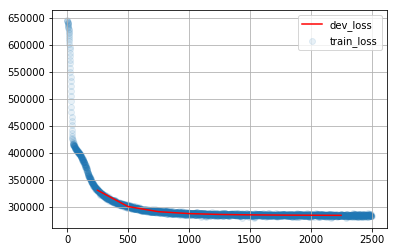

Generated examples (tau=0.5):
 Funden the pereand toptor heveral orathe an we d the and as bation dederale teon rathe s arelangent 
 ther cha d aspropentict of ceser at and apersing are the he quale the s and al we fres in the seacol
 Renges inge seation laction the and couplitictiting ther nestin thacl batid taperems. Howetron the b
Scoring dev...
#2499 Dev loss: 284124.370





 50%|████████████████████████████████████▌                                    | 2500/5000 [1:55:29<11:34:16, 16.66s/it]

KeyboardInterrupt: 

In [78]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    loss_i, _ = sess.run([loss, train_step], {input_X: batch})
    train_history.append((i, loss_i))
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend()
        plt.grid()
        plt.show()
        print("Generated examples (tau=0.5):")
        for j in range(3):
            print(generate(lm, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])